# qiskit tutorial

작성자 : jinhuyk Mun (문진혁)

최신화 : 2025년 6월 9일

언어 : Korean(한국어)

### 개요

현재 qiskit은 양자컴퓨팅의 발전과 함께 다양한 업데이트가 진행되고 있다. 하지만 1~2년전 강의나 책을 보면 그때에 맞는 코드들로 작성이 되어있고, 현재와 호환이 되지 않는 상태도 많이 있다.

그래서 [docs(ibm-quantum)](https://docs.quantum.ibm.com)을 기준으로 qiskit을 사용하는 방법을 정리할 예정이다.

현재 글 작성일 기준은 2025년 6월 9일 기준이다.

### 목차


1. [패키지 설치](#패키지-설치)
2. [qiskit으로 회로 생성하기](#qiskit으로-회로-생성하기)
3. [Local에서 Backend 실행](#Local에서-Backend-실행)
    1. [StateVector](#StateVector)
    2. [UnitarySimulator](#UnitarySimulator)
    3. [QSAMsimulator](#QSAMsimulator)
7. [Bloch Sphere 시각화](#Bloch-Sphere-표현하기)
8. [IBMQ backend사용해보기](#IBMQ-backend사용해보기)
9. [Transpile 및 최적화](#다양한-최적화를-하여-비교하기-위해-3가지-비교모델을-두었다)
10. [estimator](#estimator)


### 패키지 설치

과거 버전을 사용하기 위해 일부러 버전을 낮추는 경우도 있지만, 내 생각에는 그렇게 되면 다른 부가적인 패키지들의 버전들도 모두 낮추거나 변경해야해서, 계속해서 최신 버전을 깔고, 거기에 익숙해지는 것을 추천하고 싶다.

- qiskit: qiskit 모듈을 담아논 곳이다. (qiskit사용을 하는데, qiskit패키지가 있어야하는건 당연한 말이다.)
- qiskit-ibm-runtime: 양자회로를 가동하는건 local simulator와 실제 ibm quantum에서 실행시킬 수 있는데, 해당 패키지는 실제 ibm에서 실행시킬 수 있게 연결해주는 패키지다.
- qiskit-aer:qiskit-ibm-runtime과 다르게, local에서 이상적인 simulator들을 담아논 패키지이다.

In [ ]:
%pip install qiskit[all]
%pip install qiskit-ibm-runtime 
%pip install qiskit-aer

그 외, numpy, matplotlib등 데이터를 분석하고 시각화 하는 도구들은 원하는거에 따라 패키지를 다운로드 하면 된다. 여기에서는 이미 깔려있다 생각하고 진행한다.

### qiskit으로 회로 생성하기

다음처럼 qiskit을 불러올 수 있다.

In [2]:
from qiskit import *

이제 한번 양자 회로를 하나 제작해본다.

제작해볼 회로 3개의 qubit $\ket{0}$을 이용하여 $ \frac{\ket{000}+\ket{111}}{\sqrt{2}}$ 을 만드는 회로이다.

해당 회로는 GHZ회로로도 알려져있고, 구현 방법은 다음과 같다.
3개의 큐비트 중 1번째 큐비트를 Hadamard 적용시켜, 다음과 같은 상태로 만든다. $\frac{1}{\sqrt{2}}({\ket{0}+\ket{1}})\ket{00}$

이후 1번째를 control bit로 하여, 2번째, 3번째에 CNOT게이트를 적용해준다. $\frac{1}{\sqrt{2}}({\ket{000}+\ket{111}})$ 

그러면 최종 상태를 측정하면 어떤 결과가 나올지를 생각해본다.

이상적인 결과로는 $\ket{000}$과 $\ket{111}$이 1/2의 확률로 측정이 될것이다.


이제 회로를 구성해보자.

In [3]:
circ = QuantumCircuit(3) # 3개의 qubit을 갖는 양자 회로 생성
circ.h(0)  # 첫 번째 qubit에 Hadamard 게이트 적용
circ.cx(0, 1)  # 첫 번째 qubit에서 두 번째 qubit으로 CNOT 게이트 적용
circ.cx(0, 2)  # 첫 번째 qubit에서 세 번째 qubit으로 CNOT 게이트 적용

# 측정 부분도 미리 구현
meas = QuantumCircuit(3,3)
meas.barrier([0,1,2])
meas.measure([0,1,2],[0,1,2])  # 모든 qubit을 측정

# 양자회로와 측정회로는 나중에 측정이 필요한 경우에 합쳐서 실행할것이므로, 지금은 분리

위에서 회로를 구성했고, 우리는 이를 시각화하여 볼 수 있다.

In [4]:
circ.draw()

┌───┐          
q_0: ┤ H ├──■────■──
     └───┘┌─┴─┐  │  
q_1: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘

다음처럼 draw()를 이용하여 표현을 할 수 있지만, matplotlib를 이용하면 보다 더 깔끔하게 그림을 뽑을 수  있다.

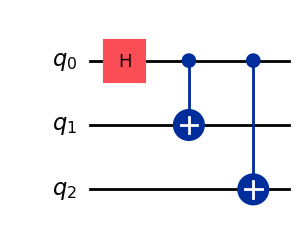

In [5]:
circ.draw('mpl')

전보다 그림이 더 깔끔해졌다.

### Local에서 Backend 실행

이제 위에서 제작한 회로를 직접 run시켜야한다. 

아까도 말했듯, Local환경에서 simulator로 돌리는 것과 실제 ibm-quantum을 이용하여 돌리는 두가지 방법이 있다. 먼저 local에서 backend를 설정 후 실행시키는 것부터 진행한다.

우리는 여기에서 3가지의 simulator를 사용할 예정이다.

- StatevectorSimulator - 현재의 양자상태를 벡터로 표현하는 시뮬레이터
- UnitarySimulator - 현재 회로에서 사용되는 Unitary연산자를 계산하는 시뮬레이터
- qasmSimulator - 측정기반의 시뮬레이터
- AerSimulator - 벡엔드로 사용하기 좋은 시뮬레이터 (앞으로는 이걸 많이 사용)

In [6]:
from qiskit_aer import  StatevectorSimulator, UnitarySimulator, QasmSimulator, AerSimulator

그리고 측정 결과들을 histogram에 보여주기 위해서 해당 모듈도 준비한다.

In [7]:
from qiskit.visualization import plot_histogram

#### StateVector

statevector는 현재의 회로의 양자 상태를 vector로 나타내준다.

중요한점은, 측정 전에 회로를 사용해야한다는 것이다. 측정 이후에는 이미 상태가 중첩상태에서 하나로 정해지기 때문에, 꼭 측정하기 전의 회로를 사용하여 현재 어떤 중첩상태인지를 아는데 사용한다.

In [8]:
backend = StatevectorSimulator()
state_job = backend.run(circ).result()
outputstate = state_job.get_statevector(decimals=1)

다음과 같은 작업으로 job에는 statevector Simulator로 circ을 실행한 결과를 담게 된다. 그리고 이걸 get_statevector로 우리가 시각화할수 있는 자료로 저장한다.

decimals는 저장할 소숫점 자리 수를 의미한다. vector는 complex형태로 저장되기 떄문에, 원하는 만큼 소숫점을 저장하면 된다.

$\ket{000}, \ket{001}, \ket{010}, \ket{011}, \ket{100}, \ket{101}, \ket{110}, \ket{111}$ 의 상태에 대해서 각 확률 분포를 나타내는 outputstate를 출력하면 다음과 같다.

In [9]:
print(outputstate)

Statevector([0.7+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
             0.7+0.j],
            dims=(2, 2, 2))


우리는 $ \frac{\ket{000}+\ket{111}}{\sqrt{2}}$ 와 같은 결과를 얻고 싶은데, 해당 statevector를 보면 잘 얻어진 것을 알수 있다.

이제 해당 중첩 결과를 histogram에 나타내보면 다음처럼 코드를 작성할 수 있다.

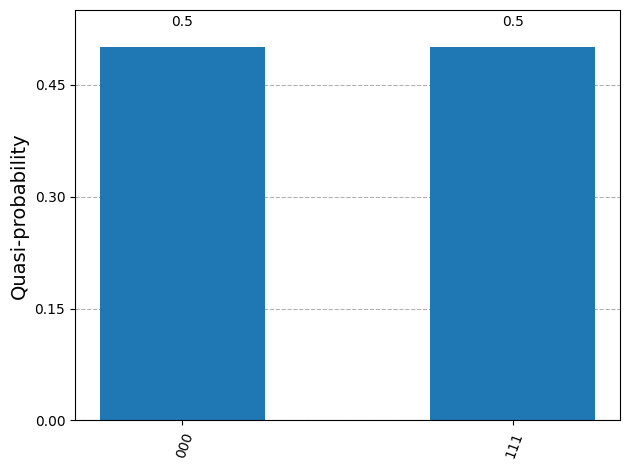

In [10]:
plot_histogram(state_job.get_counts())

#### UnitarySimulator

unitary operator는 
$U\ket{\psi} = \ket{\psi _2}$ 에서 $U$를 matrix형태로 나타내주는 backend simulator이다.

전체 회로에 대해서 Unitary Operator를 나타내준다. 해당 기능을 이용하여 연산자를 확인 하고, 회로를 검증하는데 사용된다.

In [11]:
backend = UnitarySimulator()
unitary_job= backend.run(circ).result()
operator = unitary_job.get_unitary(decimals=3)

get_unitary를 이용하여 operator에 회로에서 사용한 unitary operator가 담겼다.

In [12]:
print(operator)

Operator([[ 0.707+0.j,  0.707-0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
            0.   +0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
            0.   +0.j,  0.707+0.j, -0.707+0.j],
          [ 0.   +0.j,  0.   +0.j,  0.707+0.j,  0.707-0.j,  0.   +0.j,
            0.   +0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,  0.707+0.j,
           -0.707+0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,  0.707+0.j,
            0.707-0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.   +0.j,  0.707+0.j, -0.707+0.j,  0.   +0.j,
            0.   +0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
            0.   +0.j,  0.707+0.j,  0.707-0.j],
          [ 0.707+0.j, -0.707+0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
            0.   +0.j,  0.   +0.j,  0.   +0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 

다음 행렬을 보기 좋게 변환하고 싶다면 다음처럼 pandas와 numpy를 이용하여 변환시키면 된다.

In [13]:
import numpy as np
import pandas as pd

df = pd.DataFrame(np.array(operator.data))
print(df)

              0             1             2             3             4  \
0  0.707+0.000j  0.707-0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j   
1  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j   
2  0.000+0.000j  0.000+0.000j  0.707+0.000j  0.707-0.000j  0.000+0.000j   
3  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.707+0.000j   
4  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.707+0.000j   
5  0.000+0.000j  0.000+0.000j  0.707+0.000j -0.707+0.000j  0.000+0.000j   
6  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j   
7  0.707+0.000j -0.707+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j   

              5             6             7  
0  0.000+0.000j  0.000+0.000j  0.000+0.000j  
1  0.000+0.000j  0.707+0.000j -0.707+0.000j  
2  0.000+0.000j  0.000+0.000j  0.000+0.000j  
3 -0.707+0.000j  0.000+0.000j  0.000+0.000j  
4  0.707-0.000j  0.000+0.000j  0.000+0.000j  
5  0.000+0.000j  0.000+0.000j  0.000+0.000j  
6 

### QSAMsimulator

qsam_simulator는 측정을 하는 시뮬레이터로, 어떤 회로에 대해서 양자컴퓨터처럼 측정을 해준다.
그러므로, 꼭 회로에는 측정회로가 있어야한다.

우리는 아까 meas에 측정회로를 구현했으므로, circ와 meas를 합친 ghz라는 회로를 만들 수 있다.


In [14]:
ghz = circ & meas # 양자 회로와 측정 회로를 합침
ghz.draw()

┌───┐           ░ ┌─┐      
q_0: ┤ H ├──■────■───░─┤M├──────
     └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
q_1: ─────┤ X ├──┼───░──╫─┤M├───
          └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
q_2: ──────────┤ X ├─░──╫──╫─┤M├
               └───┘ ░  ║  ║ └╥┘
c: 3/═══════════════════╩══╩══╩═
                        0  1  2

다른 aer 시뮬레이터와 마찬가지로 qasmSimulator를 backend로 지정하고 실행시킨다.

shots은 실행 횟수인데, 양자컴퓨터의 중첩상태는 단 하나의 상태만 측정하기 때문에, 수행횟수를 늘려 그 확률을 따져봐야한다. 이번 tutorial 에서는  1024회로 지정후 측정했다.

In [15]:
backend = QasmSimulator()
qasm_result= backend.run(ghz, shots=1024).result()

{'111': 537, '000': 487}


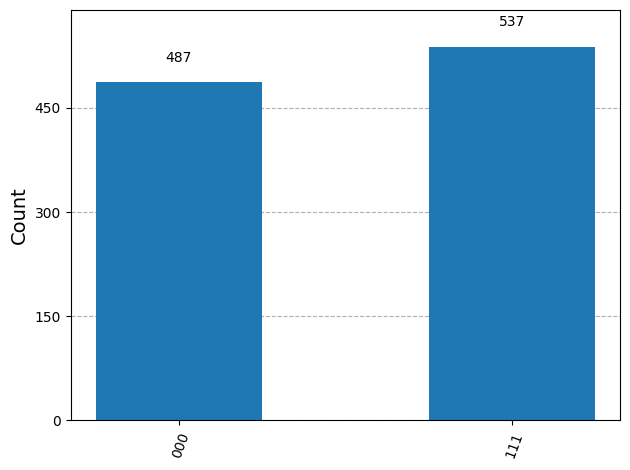

In [16]:
counts = qasm_result.get_counts()
print(counts)
plot_histogram(counts)

해당 결과를 보면 000과 111이 거의 512에 근접하게 나온다, shots을 올리면 더 절반에 가까운 수가 될것이다. 

#### Bloch Sphere 표현하기

우리는 single qubit에 대해서 해당 qubit의 상태를 Bloch 구에 나타낼 수 있다는 것을 알고있다. qiskit을 이용하면 single qubit에 대해서 bloch sphere에 나타낼 수 있다.

bloch sphere를 구현하려면 다음과 같은 모듈이 필요하다.

In [17]:
from qiskit.visualization import plot_bloch_multivector

비트 1개의 양자회로를 만들고, 중첩상태를 만들기 위해 Hadamard를 적용시킨다.

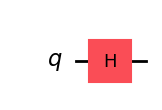

In [18]:
sq = QuantumCircuit(1)
sq.h(0)
sq.draw('mpl')

state Vector를 이용하여 vector상태로 만들어야, bloch sphere에서 표현할 수 있으므로, backend는 StatevectorSimulator를 사용해준다.

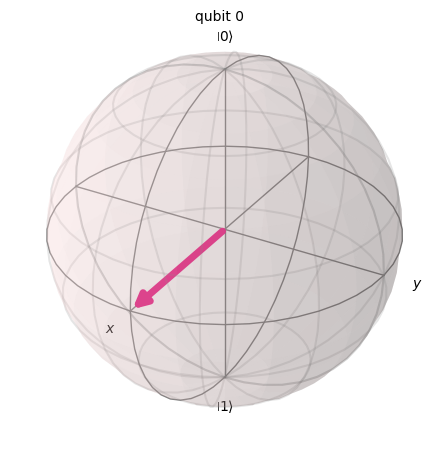

In [19]:
result = StatevectorSimulator().run(sq).result()
plot_bloch_multivector(result.get_statevector())

### IBMQ backend사용해보기

Aer을 이용하여 local에서 backend를 사용할 수 있었지만, 우리는 IBMQ의 Backend를 직접 이용할수 있다는 것을 안다.

현재 (25.06.09) 기준으로 무료 사용자는 2개의 backend를 사용할 수 있다.
하지만 25.07.01부터 IBMQ가 리뉴얼 되기 때문에, 그 뒤에 사용법은 추후에 최신화를 해야할 것같다.

IBMQ backend를 이용하기 위해서는 QiskitRuntimeService를 사용한다. 

그리고 개인 IBMQ 계정의 Token값이 필요하므로, 먼저 계정을 생성하여 IBMQ를 이용할 토큰을 가져와준다.

In [20]:
from qiskit_ibm_runtime import QiskitRuntimeService

In [ ]:

service = QiskitRuntimeService(channel='ibm_quantum',token="your_token_here")
##QiskitRuntimeService.save_account(channel='ibm_quantum', token="your_token_here")

/var/folders/s9/9g4k2dw54ps9zh7qlz1sw2yr0000gn/T/ipykernel_48030/3966887026.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(channel='ibm_quantum',token="225b98c43483700636f15b975d90a0ea2c61b750f6d983855504c7413ede8f84c80ae420dd51139f24c0dcd03c8529b81be337eb606b6764d5e3319368a7d71b")


다음 형식처럼 바로 토큰을 넣어 사용할 수 있지만, 대부분은 save_account를 이용하여 불필요하게 코드가 길어지는 것을 막는다.

save_account를 이용하면 꼭 QiskitRuntimeService에 토큰을 다 넣지 않아도, 기존에 넣은 토큰이 저장되어있어 바로 사용이 가능하다

이후 다음 코드로 service에 나의 IBMQ service를 넣어준다./ save_account()를 한 경우 사용하기

In [ ]:
# save_account()를 사용하는 경우에 실행
service = QiskitRuntimeService()

다음 코드를 치게 되면 현재 사용가능한 hardware backend를 알 수 있다.

In [22]:
service.backends()

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>]

이제 우리는 실제 IBMQ backend중 하나를 회로 측정에 사용할 backend로 지정해줄 수 있다.
다음 코드는 현재시점에서 사용하기 좋은 hardware backend를 정해준다.

In [27]:

backend = service.least_busy(simulator=False, operational=True)

그러면 이제 우리가 위에서 만든 ghz회로를 실제 backend를 이용하여 측정해보자.

그 전에 transpile이라는 작업을 해야한다.

transpile이란, 우리는 이론적으로 회로를 구성했지만 실제 IBMQ hardware Backend들은 해당 연산자들을 바로 적용시킬 수 없다. 그래서, 이를 최적화하여 해당 벡엔드에서 돌릴 수 있게 만들어주는 작업이라고 생각하면 된다.

generate_preset_pass_manager는 optimization level을 설정할 수 있는데, 다음과 같다.

0 
최소한의 변환
측정 순서, 게이트 타입만 변환 (기본 정합성 확보)
회로 구조 그대로 두고 백엔드 맞춤만

1
경량 최적화
일부 게이트 병합, 깊이 감소
빠른 실행, 약간의 최적화

2
균형 잡힌 최적화
회로 깊이와 게이트 수 최적화
일반적인 회로 실행용

3
고강도 최적화
최적 경로 탐색, 반복 최적화, commutative gate 제거
성능 중요 시 (예: NISQ 환경)


또한 transpile을 하는 방법은 내부의generate_preset_pass_manager를 이용하는 방법과 transpile을 이용하는 방법 두가지가 있다.

generate_preset_pass_manager는 pass만 만들어서 다양하게 회로에 적용시킬 수 있고, 

transpile은 회로에 대해서 transpile된 회로를 만드는데 사용된다.

실제 hardware backend를 사용할 때에는, n-qubit의 에러율 고려들도 해야한다. 만약 고려하지 않고, transpile 을 하게 되면 밑에 result2와 같이 정확도가 떨어질 수 있다.


다양한 최적화를 하여 비교하기 위해 3가지 비교모델을 두었다.

첫번째는 그냥 transpile만 한경우, 두번째는 pass_manager만 조작한 경우, 세번째는 transpile에 내부 설정을 (chat-gpt를 이용하여 최적화)한 경우이다.

In [28]:
from qiskit.transpiler import generate_preset_pass_manager

ghz = circ & meas 
ghz.draw()

opt_ghz = transpile(ghz,backend,1)
opt_str_ghz = transpile(
    ghz,
    backend,
    3,
    layout_method="sabre",
    routing_method="lookahead",
    translation_method="translator",
    seed_transpiler=42
)
pm = generate_preset_pass_manager(backend, 1)
pm_opt_ghz = pm.run(ghz)


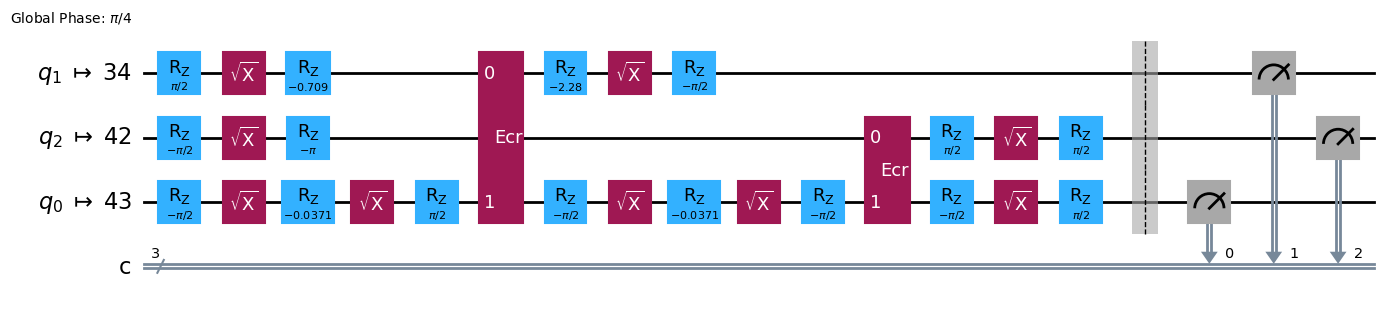

In [29]:
pm_opt_ghz.draw('mpl')

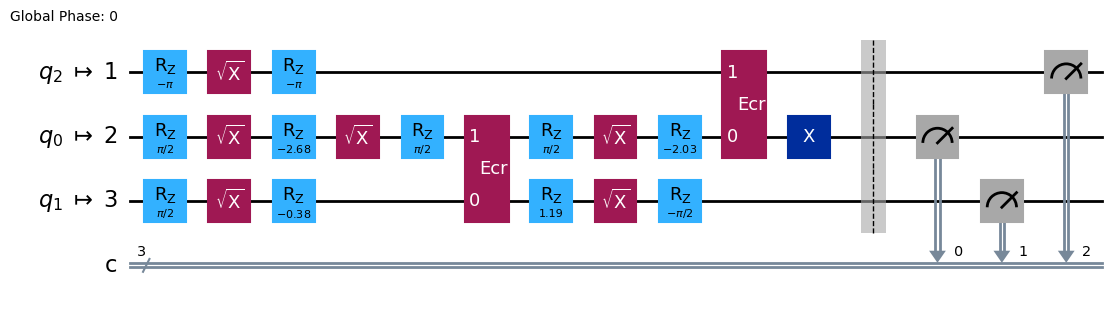

In [30]:
opt_ghz.draw('mpl')

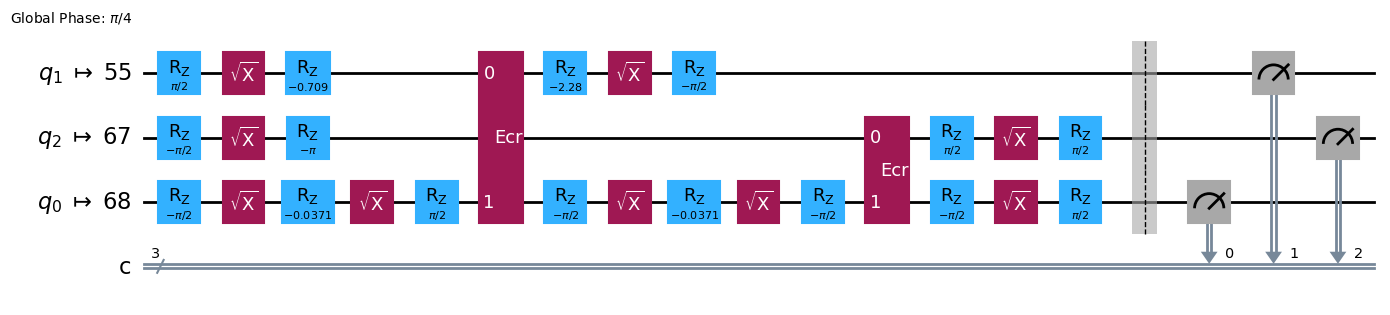

In [31]:
opt_str_ghz.draw('mpl')

pm은 현재 backend에서 어떤 회로에 대해 최적화할수 있는 pass그 자체고,

opt_ghz는 ghz를 backend에 대해 최적화한 회로이다.

opt_str_ghz는 ghz에 transpile을 할때, 조건 등을 추가 설정을 해준 유사한 최적화 회로이다. (chat GPT가 작성)

그리고 해당 상태들에 대해서 hardware가 statevector를 만드려면 다음과 같은 작업을 하면 된다.

sampler를 이용하여 우리는 Aer의 StatevectorSimulator와 동일한 작업을 진행 시킬 수 있다. (sampler사용은 다음 장에 설명되어있다)

어떤 작업에 대해서 묶어서 작업하고 싶은 경우에 session을 이용하여 사용할 수 있다.

In [32]:
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

with Session(backend) as session:
    sampler = Sampler(session)
    job1 = sampler.run([pm_opt_ghz],shots=1024)
    job2 = sampler.run([opt_ghz],shots=1024)
    job3 = sampler.run([opt_str_ghz],shots=1024)
    result1 = job1.result()
    result2 = job2.result()
    result3 = job3.result()


/opt/miniconda3/envs/qiskit/lib/python3.13/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


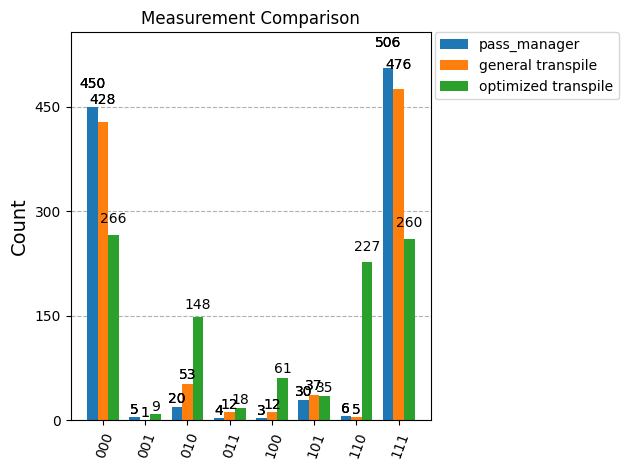

In [33]:
counts1 = result1[0].data.c.get_counts()
counts2 = result2[0].data.c.get_counts()
counts3 = result3[0].data.c.get_counts()

# 하나의 그래프에 겹쳐서 표시
plot_histogram(
    [counts1, counts2, counts3],
    legend=["pass_manager", "general transpile", "optimized transpile"],
    title="Measurement Comparison"
)

transpile에 대해서 위와 같이 차이가 많이나게 되는 경우를 알고 있다면, issue에 남겨주길 바랍니다.

다음 코드를 사용하여 현재 qubit의 Error map을 알아볼 수 있다.

간단히 알아보자면 각 node는 qubit를 나타내고, edge는 서로 연결된 길을 의미한다.

그래서 우리가 transpile이 꼭 필요한 이유가, 우리는 0번 qubit부터 회로를 설계하지만 실제로 해당 회로는 그 qubit끼리 연결이 안되어있다면, transpile을 통해 최적화와 변형을 시켜줘야한다는 것이다.

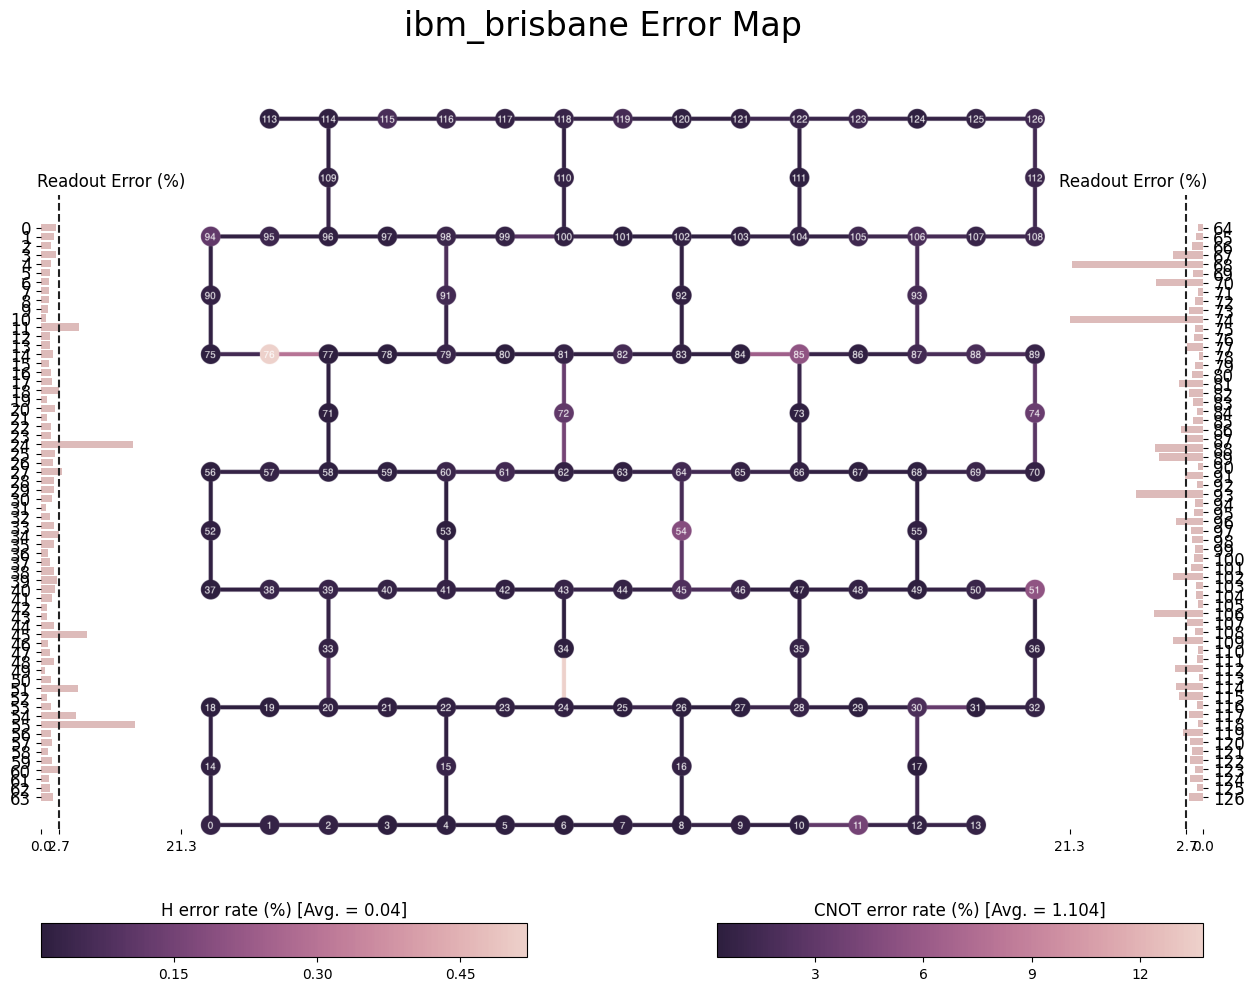

In [34]:
from qiskit.visualization import plot_error_map
plot_error_map(backend)

#### Sampler

sampler는 stateVector처럼 확률 분포를 측정하는 용도로 사용되는 방법이다. 

해당 방법은 위에서 마찬가지로 hardware backend를 통해 구현하거나, AerSimulator등 local backend를 이용해서 구현할 수 있다.


간단히 위에서 한 예제로  Aer backend를 이용하여 구현하겠다.

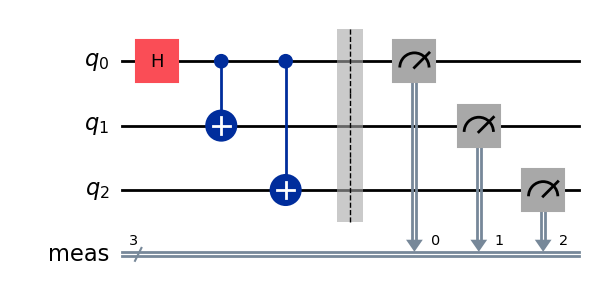

In [35]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
circ = QuantumCircuit(3)
circ.h(0)
circ.cx(0, 1)
circ.cx(0, 2)
circ.measure_all()

circ.draw('mpl')


Sampler를 사용하는 경우, sampler의 인자로 backend를 사용하면 되고, shots을 지정해주면 된다.

In [37]:
be = AerSimulator()
job = Sampler(be).run([circ], shots=1024)
result = job.result()

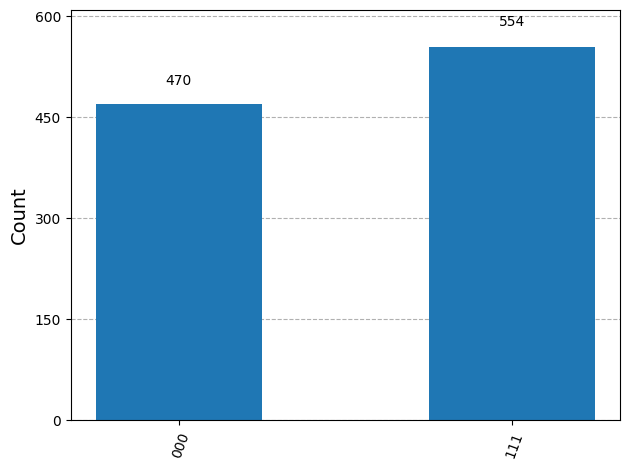

In [39]:
plot_histogram(result[0].data.meas.get_counts())

우리가 state vector에서 구한것과 마찬가지로 비슷한 결과를 얻을 수 있다.

#### estimator

estimator는 관측자에 대해 기댓값을 측정하는 방법이다. 해당 방법도 hardware backend를 통해 구현을 할 수 있다.

우리는 먼저 두가지 상태를 가져와볼 것이다.

$\frac{1}{\sqrt{2}}(\ket{0}+\ket{1})$ 과  $\frac{1}{\sqrt{2}}(\ket{0}-\ket{1})$ 이다.

해당 상태를 측정하면 어떤 결과가 나올까? 이것을 한번 statevector simulator로 측정해보면 다음과 같을 것이다.

먼저, $\frac{1}{\sqrt{2}}(\ket{0}+\ket{1})$ 의 경우이다.

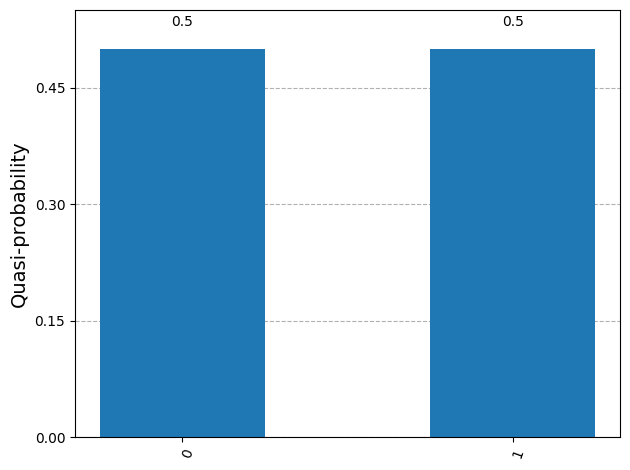

In [40]:
q1 = QuantumCircuit(1)
q1.h(0)
state_job = StatevectorSimulator().run(q1).result()
outputstate = state_job.get_statevector(decimals=1)
plot_histogram(state_job.get_counts())

다음은 , $\frac{1}{\sqrt{2}}(\ket{0}-\ket{1})$ 의 경우이다.

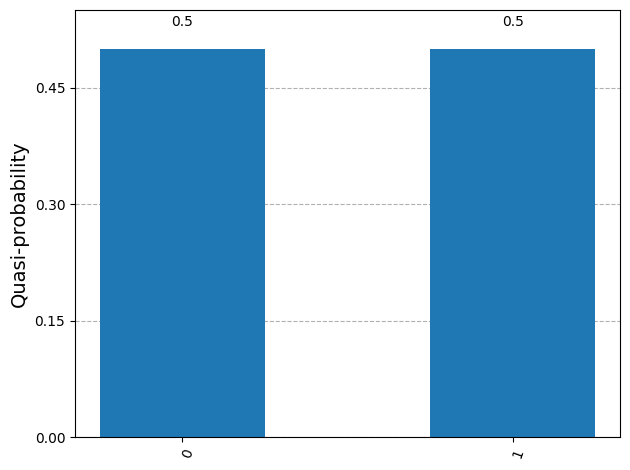

In [41]:
q2 = QuantumCircuit(1)
q2.x(0)
q2.h(0)
state_job = StatevectorSimulator().run(q2).result()
outputstate = state_job.get_statevector(decimals=1)
plot_histogram(state_job.get_counts())

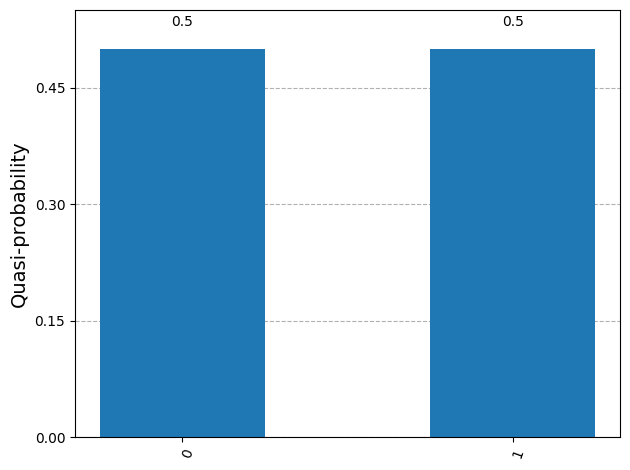

In [42]:
q3 = QuantumCircuit(1)
q3.h(0)
state_job = StatevectorSimulator().run(q3).result()
outputstate = state_job.get_statevector(decimals=1)
plot_histogram(state_job.get_counts())

결과를 예상했다시피, 두개의 statevector는 동일하게 나온다. 그러면 우리는 다음 두 상태를 구분하려면 어떻게 해야할까

이때, 측정을 해볼 수 있는데, 당연하게도 현재 상태에서 측정하면 0과 1이 절반의 확률로 측정이 될 것이다.
그래서 우리는, 두 회로에 모두 Hadamard를 적용시켜 간섭을 시켜줄 것이다. 그러면 $\ket{0}$으로 측정을 헀을 때, 어떤 회로는 계속 측정되고, 어떤 것은 측정이 안될 것이다.

이를 한번 구현하기 위해서는 일단, 관측자라는 개념이 들어오게 된다.

qiskit estimator는 관측자를 pauli Operator를 통해서만 받는다고 한다. 그래서 적절하게 pauli Operator basis를 이용하여 원하는 Projector를 만들면 된다.

In [44]:
q1.h(0)
q2.h(0)

다음을 통해, q1과 q2에 hadamard를 적용해주었다.

그리고 PauliOP을 이용하여 basis를 조합하여 $\ket{0}$관측자를 만들었다.

In [45]:
from qiskit.quantum_info import SparsePauliOp
PZ = SparsePauliOp.from_list([("Z", 0.5), ("I", 0.5)])


해당 측정을 하기 위해 Backend는 AerSimulator를 이용해줄것이다.

위에서 소개는 안했지만, local simulator중에서 사용하기 좋은 backend이다.

In [46]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
be = AerSimulator()

result1 = Estimator(be).run([(q1,PZ)]).result()
result2 = Estimator(be).run([(q2,PZ)]).result()
result3 = Estimator(be).run([(q3,PZ)]).result()

In [47]:
print(result1[0].data.evs)
print(result2[0].data.evs)
print(result3[0].data.evs)

1.0
0.0
0.495361328125


다음과 같은 결과를 얻을 수 있다.
result3인 경우에는 기존의 중첩 상태를 $\ket{0}$으로 재면 어떨지를 나타냈다.
우리가 예상한 대로, 1,0,0.5가 나오게 되었다.

### 결론

지금까지 2025년 6월 기준으로 qiskit을 사용하는 기초를 정리해보았다.

qiskit은 계속해서 업데이트하고 있기 때문에, 해당 기술을 잘 익히기 위해서는 계속해서 새로운 docs를 읽고, 정리해보아야한다.

이번 tutorial을 통해 quantum circuit을 구현하는 방법, Aer을 이용하여 local simulator을 사용하는 방법, ibm hardware backend을 이용하는 방법, sampler, estimator를 사용하는 방법에 대해서 정리해보았다.